In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Scaling
from sklearn.preprocessing import RobustScaler, LabelEncoder

# Train Test Split
from sklearn.model_selection import train_test_split

# Models
import torch
import torch.nn as nn
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Metrics
from sklearn.metrics import accuracy_score, classification_report, roc_curve

# Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv


In [2]:
data = pd.read_csv("/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv")
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# Fields and Data Types 📊:
The dataset includes the following attributes:
1) id: unique identifier
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) stroke: 1 if the patient had a stroke or 0 if not

- *Note*: "Unknown" in smoking_status means that the information is unavailable for this patient

# Understanding Data

In [3]:
data.shape

(5110, 12)

## Now i going to checking the number of unique values in each column

In [4]:
dict = {}
for i in list(data.columns):
    dict[i] = data[i].value_counts().shape[0]

pd.DataFrame(dict,index=["unique count"]).transpose()

,unique count
id,5110
gender,3
age,104
hypertension,2
heart_disease,2
ever_married,2
work_type,5
Residence_type,2
avg_glucose_level,3979
bmi,418


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [6]:
print("=".center(50, "="))
cat_cols = ['gender' ,'ever_married','work_type','Residence_type','smoking_status']
num_cols = ['age', 'hypertension', 'heart_disease','avg_glucose_level', 'bmi']
target_col = ["stoke"]
print("The categorial cols are : ", cat_cols)
print("The continuous cols are : ", num_cols)
print("The target variable is :  ", target_col)
print("=".center(50, "="))

The categorial cols are :  ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
The continuous cols are :  ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
The target variable is :   ['stoke']


# Summary statistics

In [7]:
data[num_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60


# Missing values

In [8]:
data.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

# Filling the values with mean

In [9]:
data["bmi"].fillna(data["bmi"].mean(), inplace=True)

In [10]:
data.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

# EDA (Exploratory Data Analysis)

In [11]:
print("=".center(50, "="))
print('work_type : ', data['work_type'].unique())
print('gender : ', data['gender'].unique())
print('Residence_type : ', data['Residence_type'].unique())
print('ever"_married : ', data['ever_married'].unique())
print('smoking_status : ', data['smoking_status'].unique())
print("=".center(50, "="))

work_type :  ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
gender :  ['Male' 'Female' 'Other']
Residence_type :  ['Urban' 'Rural']
ever"_married :  ['Yes' 'No']
smoking_status :  ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


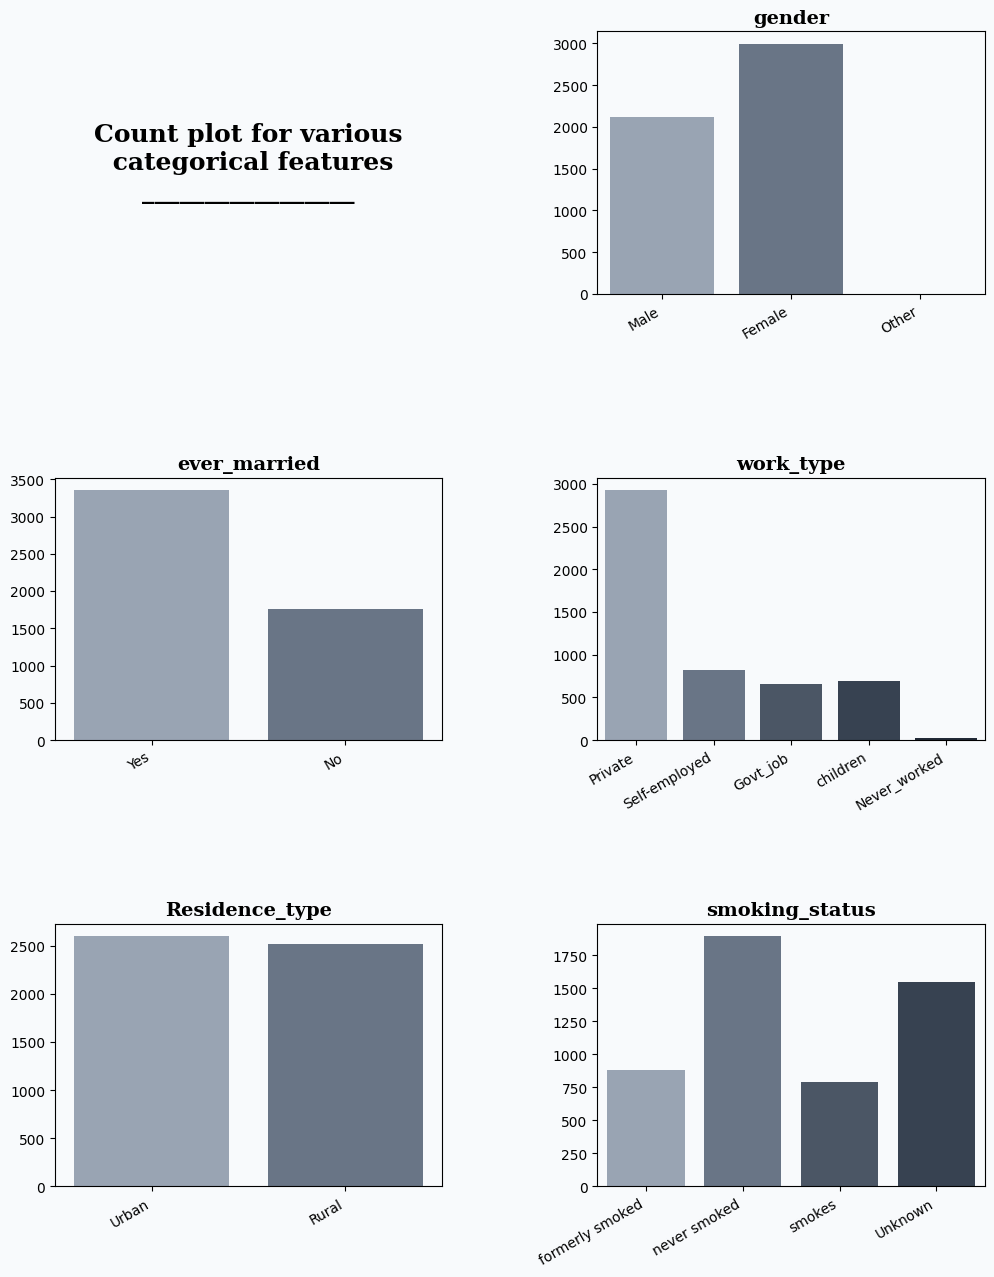

In [12]:
# Figure adjustments

# Larger size for better visualization
fig = plt.figure(figsize=(12, 15))  
gs = fig.add_gridspec(3, 2)
# Increases space between subplots
gs.update(wspace=0.4, hspace=0.7)  


background_color = "#f8fafc"
color_palette = ["#94a3b8", "#64748b", "#475569", "#334155", "#1e293b"]
fig.patch.set_facecolor(background_color)
axes = [fig.add_subplot(gs[i,j]) for i in range(3) for j in range(2)]
for ax in axes:
    ax.set_facecolor(background_color)

# Title of the plot
axes[0].spines["bottom"].set_visible(False)
axes[0].spines["left"].set_visible(False)
axes[0].spines["top"].set_visible(False)
axes[0].spines["right"].set_visible(False)
axes[0].tick_params(left=False, bottom=False)
axes[0].set_xticklabels([])
axes[0].set_yticklabels([])
axes[0].text(0.5, 0.5,
             'Count plot for various\n categorical features\n_________________',
             horizontalalignment='center',
             verticalalignment='center',
             fontsize=18, fontweight='bold',
             fontfamily='serif',
             color="#000000")

# Plot for each categorical feature
plot_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
titles = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

for i, feature in enumerate(plot_features):
    ax = axes[i + 1]
    ax.set_title(titles[i], loc='center', fontsize=14, fontweight='bold', fontfamily="serif", color="#000000")
    sns.countplot(ax=ax, data=data, x=feature, palette=color_palette)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', fontsize=10)

# Adjust and show
plt.show()

## Bivariate Analysis

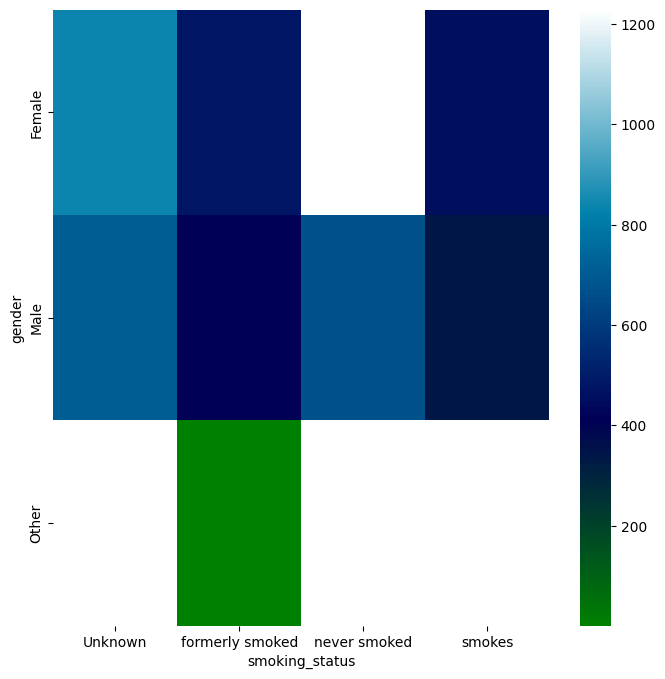

In [13]:
# Gender vs Smoking_Status
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['gender'].value_counts()
    for x_label, grp in data.groupby('smoking_status')
})
sns.heatmap(df_2dhist, cmap='ocean')
plt.xlabel('smoking_status')
_ = plt.ylabel('gender')

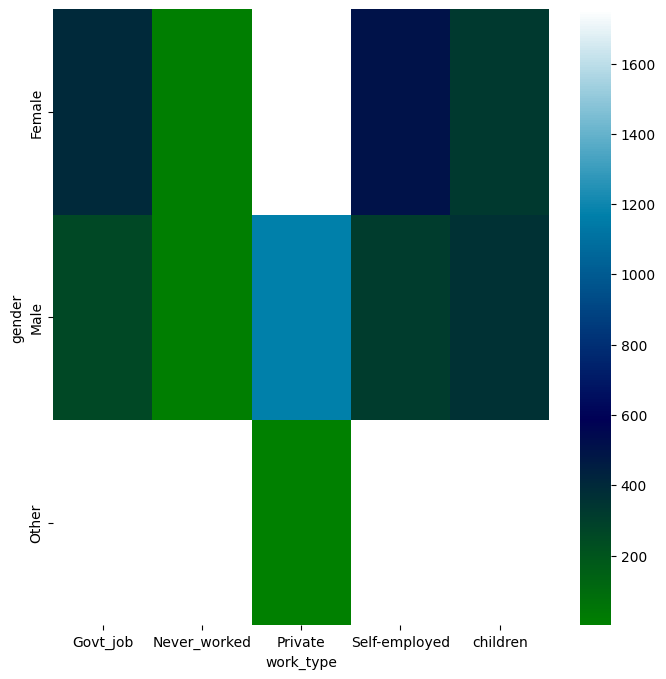

In [14]:
# Gender vs Work_Type
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['gender'].value_counts()
    for x_label, grp in data.groupby('work_type')
})
sns.heatmap(df_2dhist, cmap='ocean')
plt.xlabel('work_type')
_ = plt.ylabel('gender')

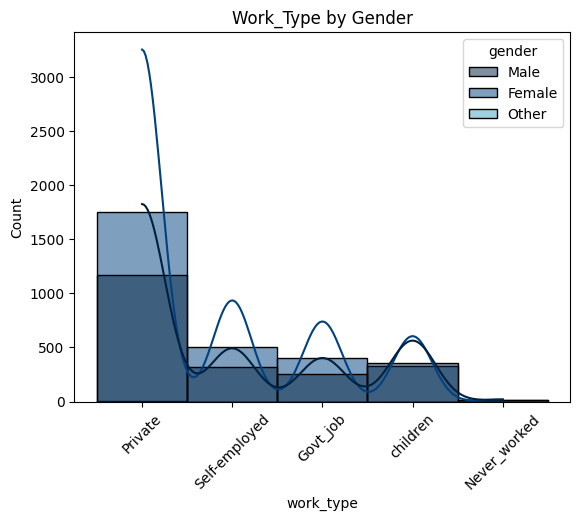

In [15]:
# Work_Type by Gender
plt.xticks(rotation=45)
sns.histplot(data=data, x='work_type', hue="gender",palette="ocean", kde=True)
plt.title('Work_Type by Gender')
plt.show()

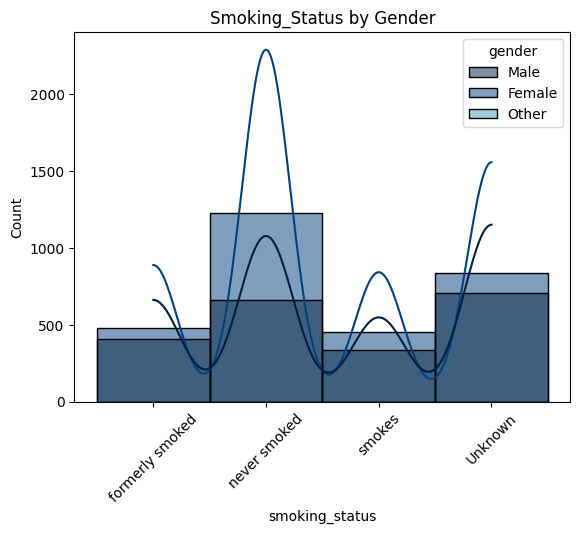

In [16]:
# Smoking_Status by Gender
plt.xticks(rotation=45)
sns.histplot(data=data, x='smoking_status', hue="gender",palette="ocean", kde=True)
plt.title('Smoking_Status by Gender')
plt.show()

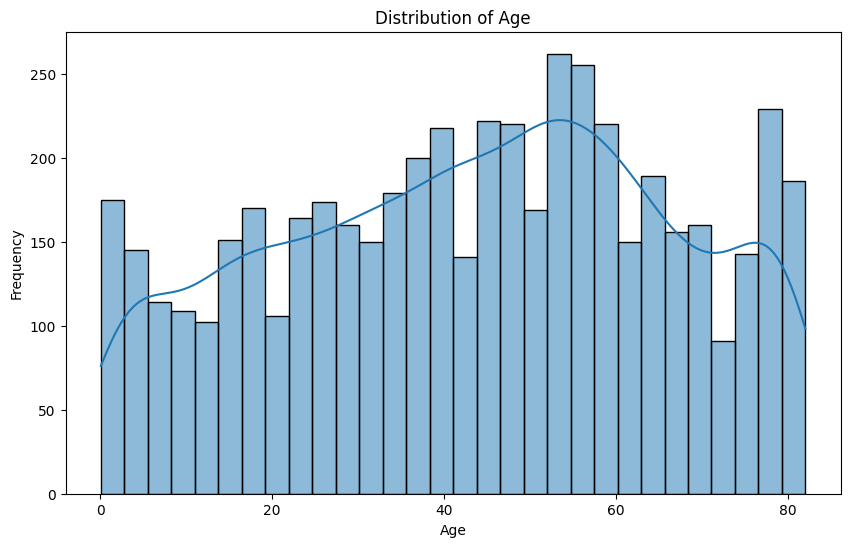

In [17]:
# Distribution of Age
plt.figure(figsize=(10, 6))
sns.histplot(data['age'], palette="ocean" , kde=True, bins=30)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

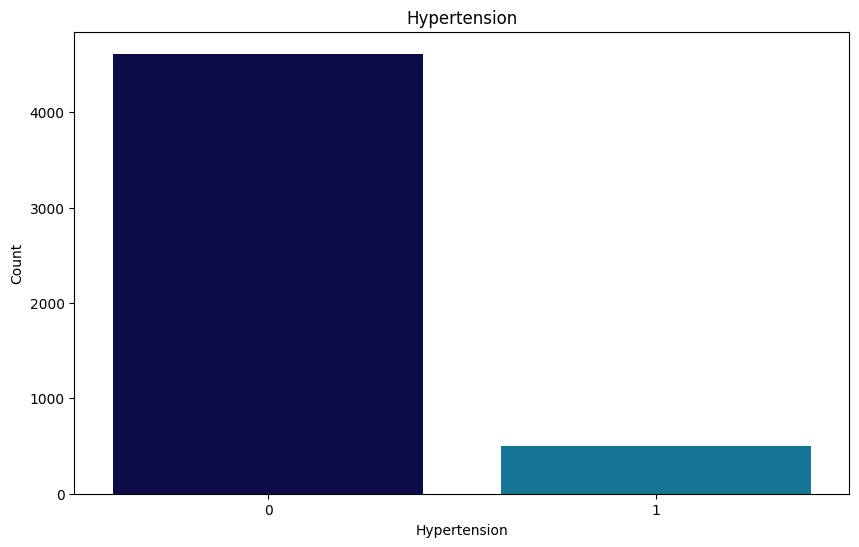

In [18]:
# Distribution of Hypertension
plt.figure(figsize=(10, 6))
sns.countplot(x='hypertension', data=data, palette="ocean")
plt.title('Hypertension')
plt.xlabel('Hypertension')
plt.ylabel('Count')
plt.show()

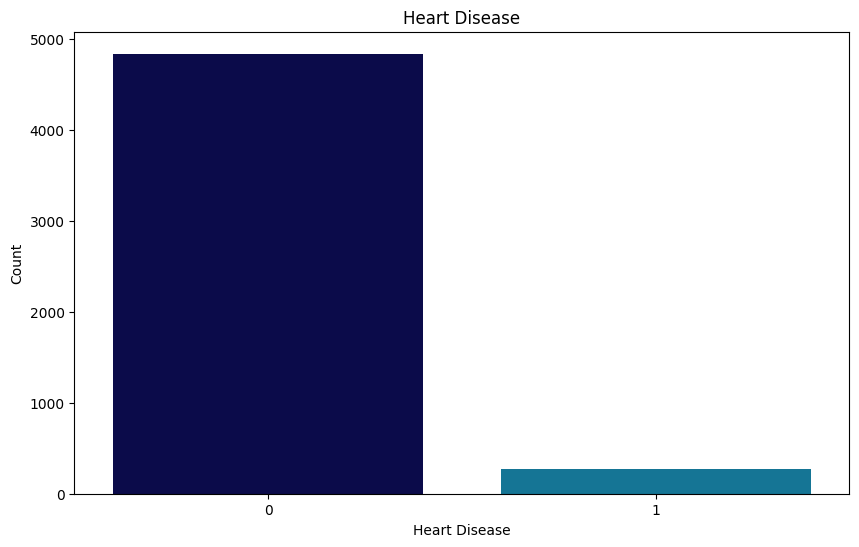

In [19]:
# Distribution of Heart Disease
plt.figure(figsize=(10, 6))
sns.countplot(x='heart_disease', data=data, palette="ocean")
plt.title('Heart Disease')
plt.xlabel('Heart Disease')
plt.ylabel('Count')
plt.show()

### Age, BMI, Average glucose level vs Stroke

Text(0.5, 1.0, 'Age vs Stroke')

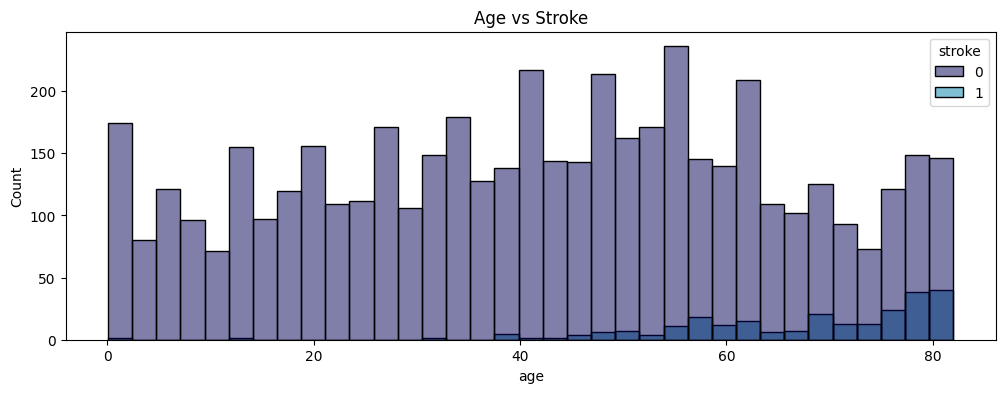

In [20]:
plt.figure(figsize=(12, 4))
sns.histplot(x='age', data=data, palette="ocean", hue='stroke', bins=35)
plt.title("Age vs Stroke")

Text(0.5, 1.0, 'Average Glucose Level vs Stroke')

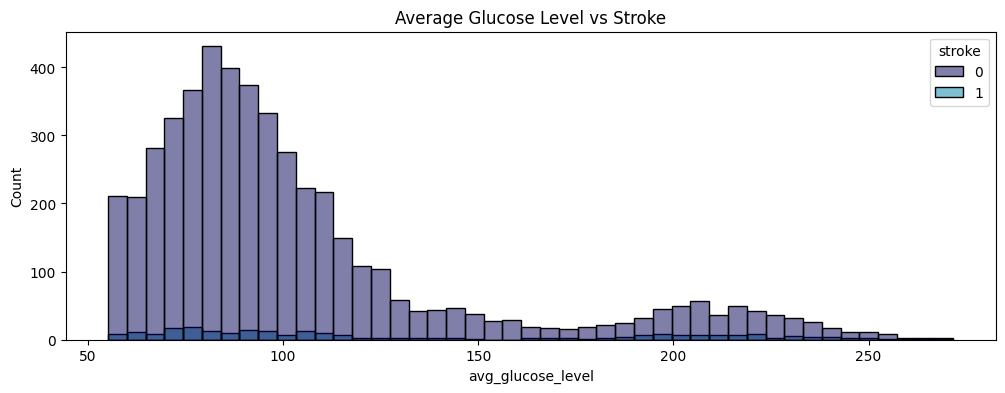

In [21]:
plt.figure(figsize=(12, 4))
sns.histplot(x='avg_glucose_level', data=data, palette="ocean" ,hue='stroke', bins=45)
plt.title("Average Glucose Level vs Stroke")

Text(0.5, 1.0, 'BMI vs Stroke')

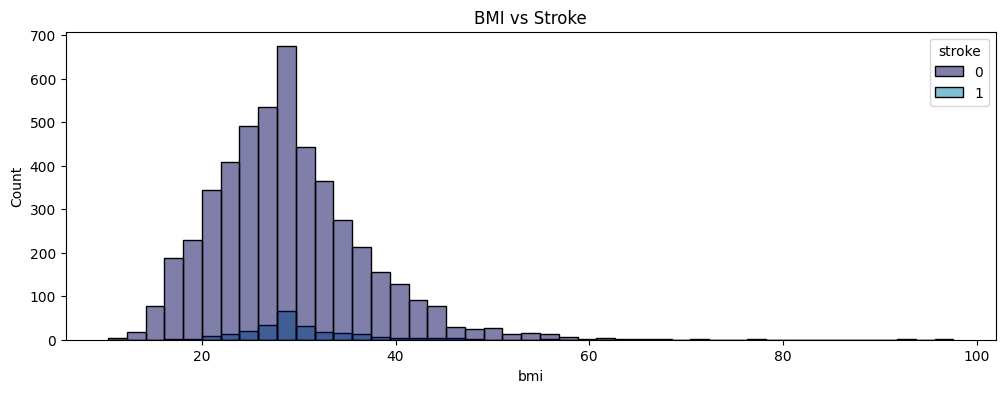

In [22]:
plt.figure(figsize=(12, 4))
sns.histplot(x='bmi', data=data, palette="ocean" ,hue='stroke', bins=45)
plt.title("BMI vs Stroke")

# Details / Information:

- Age vs Stroke:
    1. Stroke incidents increase notably after age 40
    2. The highest concentration of stroke cases appears in the 60-80 age range
    3. Very few stroke cases are reported in patients under 40
    4. The overall distribution shows age is a significant risk factor for strokes

- Average Glucose Level vs Stroke:
    1. Most non-stroke cases (purple) have glucose levels between 50-150 mg/dL
    2. There's a peak distribution around 80-100 mg/dL for non-stroke cases
    3. Stroke cases (shown in small numbers at bottom) appear more frequently in higher glucose ranges
    4. The data suggests elevated glucose levels may increase stroke risk

- BMI vs Stroke:
    1. The majority of the population has BMI between 20-40
    2. Peak distribution is around 25-35 BMI range
    3. Stroke cases (blue) appear more frequently in the overweight and obese ranges (BMI > 25)
    4. Extreme BMI values (both very low and very high) show lower case counts overall
    5. The data suggests being overweight or obese may increase stroke risk, though the relationship appears less dramatic than with age or glucose levels

# Countplots

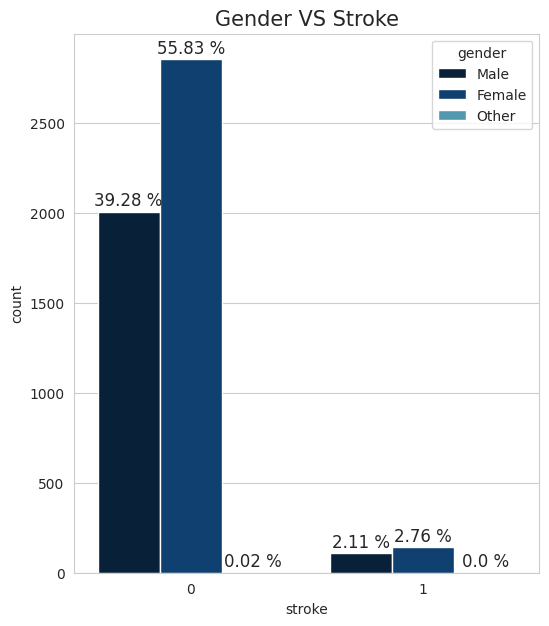

In [23]:
sns.set_style('whitegrid')
countplt, ax = plt.subplots(figsize = (6,7))
ax=sns.countplot(x=data['stroke'],hue=data['gender'],palette = 'ocean')
ax.set_title("Gender VS Stroke",fontsize = 15)

for j in ax.patches:
        ax.annotate(f'{round(j.get_height()/len(data)*100,2)} %', xy=(j.get_x() + j.get_width() / 2,  
            j.get_height()), ha='center',  va='center',size=12, xytext=(0, 8),textcoords='offset points')
plt.show()

# Details / Information:
Females: Make up the majority of the dataset (55.83% without stroke, 2.76% with stroke) compared to males (39.28% without stroke, 2.11% with stroke), though the proportion of strokes is relatively similar between genders, suggesting gender may not be a strong independent risk factor.

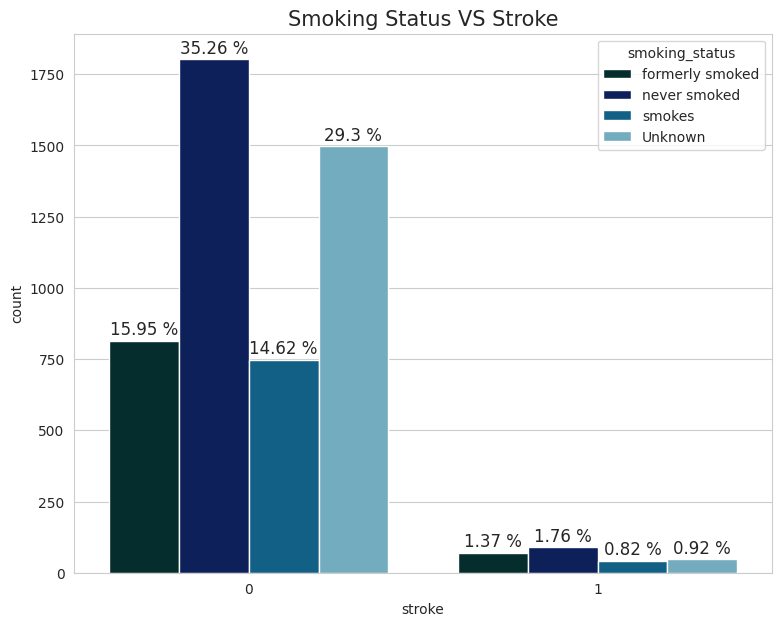

In [24]:
countplt, ax = plt.subplots(figsize = (9,7))
ax=sns.countplot(x=data['stroke'],hue=data['smoking_status'],palette = 'ocean',)
ax.set_title("Smoking Status VS Stroke",fontsize = 15)
for p in ax.patches:
        ax.annotate(f'{round(p.get_height()/len(data)*100,2)} %', xy=(p.get_x() + p.get_width() / 2,  
            p.get_height()), ha='center',  va='center',size=12, xytext=(0, 8),textcoords='offset points')
plt.show()

# Details / Information:
The highest proportion of non-stroke cases are among people who never smoked (35.26%), but interestingly, current smokers have a slightly lower stroke rate (0.82%) compared to those who never smoked (1.76%) or formerly smoked (1.37%), though this could be influenced by other factors like age distribution or sample size limitations.

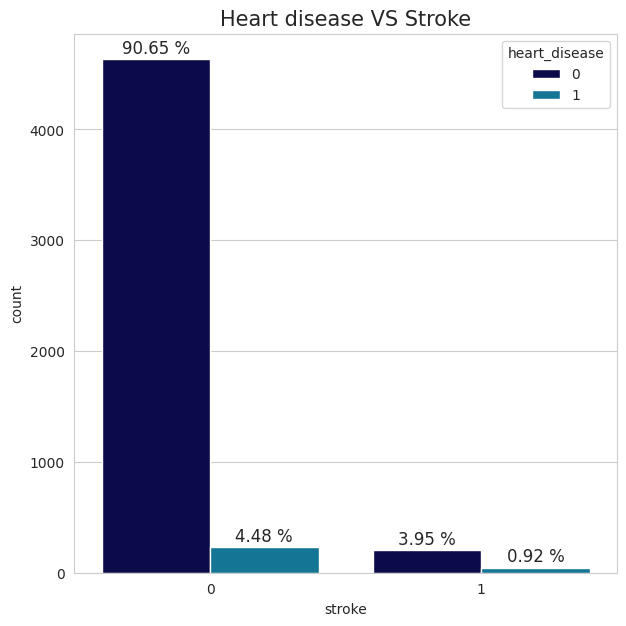

In [25]:
countplt, ax = plt.subplots(figsize = (7,7))
ax=sns.countplot(x=data['stroke'],hue=data['heart_disease'],palette = 'ocean')
ax.set_title("Heart disease VS Stroke",fontsize = 15)
for p in ax.patches:
        ax.annotate(f'{round(p.get_height()/len(data)*100,2)} %', xy=(p.get_x() + p.get_width() / 2,  
            p.get_height()), ha='center',  va='center',size=12, xytext=(0, 8),textcoords='offset points')
plt.show()

# Details / Information:
The majority of people without heart disease (90.65%) also don't have strokes (0). Among those with heart disease (1), there are relatively low stroke rates (0.92%). However, having heart disease appears to be associated with a slightly higher stroke risk compared to those without heart disease.

Text(0.5, 1.0, 'Residence Type VS Stroke')

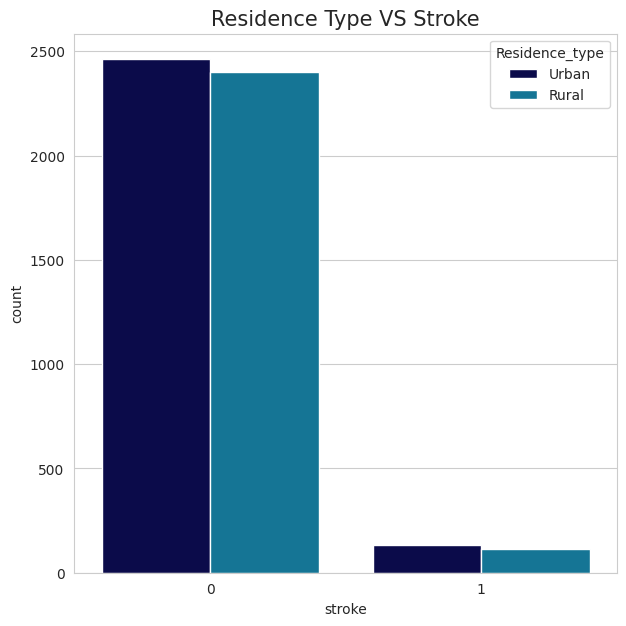

In [26]:
countplt, ax = plt.subplots(figsize = (7,7))
ax=sns.countplot(x=data['stroke'],hue=data['Residence_type'],palette = 'ocean')
ax.set_title("Residence Type VS Stroke",fontsize = 15)

# Details / Information:
The distribution between urban and rural residents is fairly even for both stroke and non-stroke groups, suggesting that residence type may not be a strong predictor of stroke risk. The overall stroke prevalence is notably lower than non-stroke cases in both residential settings.

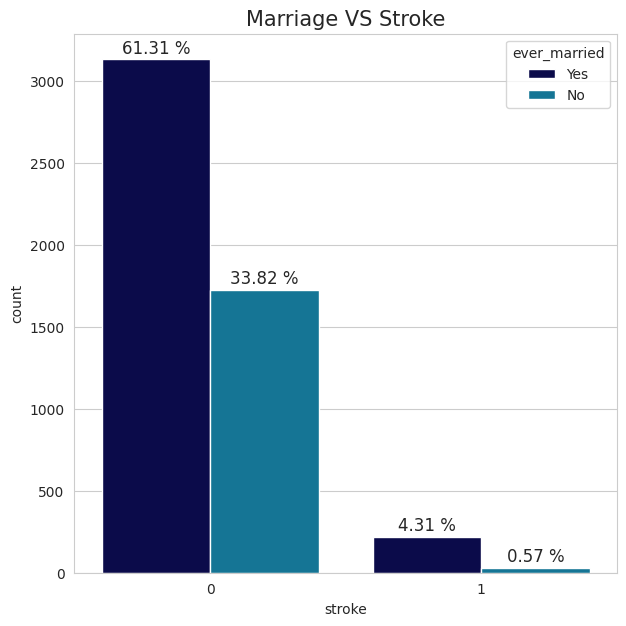

In [27]:
countplt, ax = plt.subplots(figsize = (7,7))
ax=sns.countplot(x=data['stroke'],hue=data['ever_married'],palette = 'ocean')
ax.set_title("Marriage VS Stroke",fontsize = 15)
for p in ax.patches:
        ax.annotate(f'{round(p.get_height()/len(data)*100,2)} %', xy=(p.get_x() + p.get_width() / 2,  
            p.get_height()), ha='center',  va='center',size=12, xytext=(0, 8),textcoords='offset points')
plt.show()

# Details / Information:
Among those without stroke (0), there's a notably higher percentage of married people (61.31%) compared to unmarried people (33.82%). For those who had a stroke (1), the percentages are much lower but still show higher rates among married people (4.31%) compared to unmarried (0.57%).

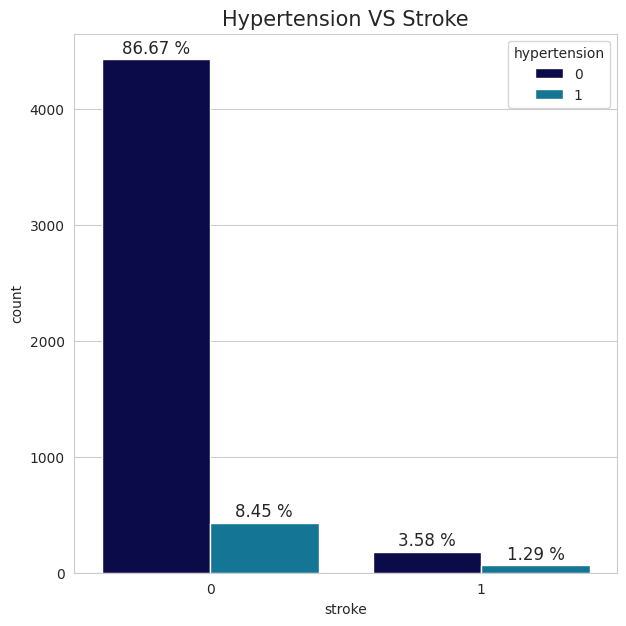

In [28]:
countplt, ax = plt.subplots(figsize = (7,7))
ax=sns.countplot(x=data['stroke'],hue=data['hypertension'],palette = 'ocean')
ax.set_title("Hypertension VS Stroke",fontsize = 15)

for p in ax.patches:
        ax.annotate(f'{round(p.get_height()/len(data)*100,2)} %', xy=(p.get_x() + p.get_width() / 2,  
            p.get_height()), ha='center',  va='center',size=12, xytext=(0, 8),textcoords='offset points')
plt.show()

# Details / Information:
People without hypertension (0) make up the largest group (86.67%) and mostly don't have strokes. Those with hypertension (1) show a higher relative risk of stroke (1.29%) compared to those without hypertension (3.58% without stroke), suggesting hypertension might be a risk factor for stroke.

# Presence of Stroke

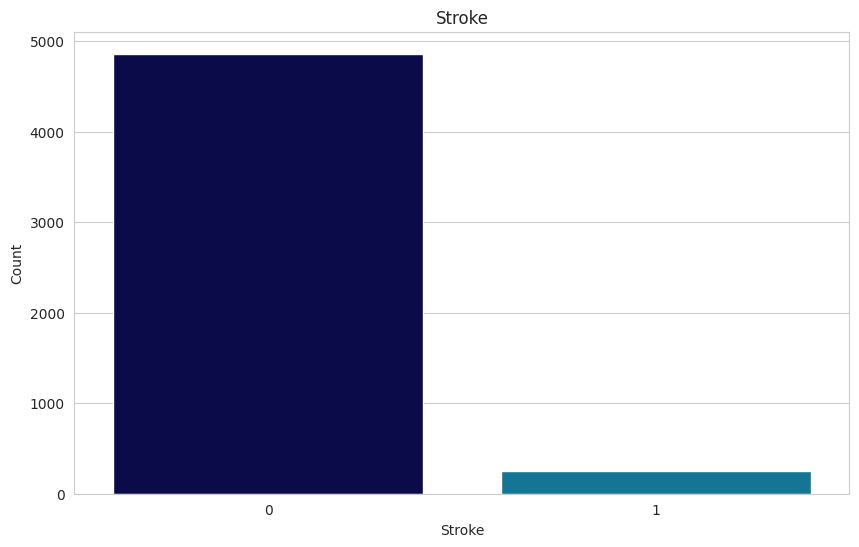

In [29]:
plt.figure(figsize=(10, 6))
sns.countplot(x='stroke', data=data, palette="ocean")
plt.title('Stroke')
plt.xlabel('Stroke')
plt.ylabel('Count')
plt.show()

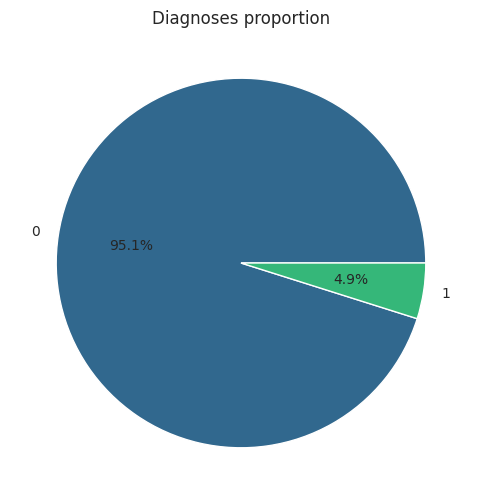

Stroke: 
 stroke
0    4861
1     249
Name: count, dtype: int64


In [30]:
plt.figure(figsize=(10,6))
labels = data['stroke'].value_counts().index.to_list()
sizes = data['stroke'].value_counts().to_list()
colors = sns.color_palette('viridis', len(labels))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title("Diagnoses proportion")
plt.show()
print("=".center(50, "="))
print("Stroke: \n" , (data['stroke']).value_counts())

In [31]:
data.shape

(5110, 12)

In [32]:
print("=".center(50, "="))
print("The number of positive cases is : 249")
print("The number of negative cases is : 4861")
print("The percentage of positive cases is :", 249/5110*100)
print("=".center(50, "="))

The number of positive cases is : 249
The number of negative cases is : 4861
The percentage of positive cases is : 4.87279843444227


# Making features model ready
## Scaling and Encoding features

In [33]:
# Creating a copy of data
data_copy = data

# Define the columns to be encoded and scaled
cat_cols = ['gender' ,'ever_married','work_type','Residence_type','smoking_status']
num_cols = ['age', 'hypertension', 'heart_disease','avg_glucose_level', 'bmi']

# Encoding the categorical columns
data_copy = pd.get_dummies(data_copy, columns = cat_cols, drop_first = True)

# Defining the feature and target
X = data_copy.drop(['stroke'], axis=1)
y = data_copy[['stroke']]

# Instantiating the Scaler
scaler = RobustScaler()

# Scaling the continuous features
X[num_cols] = scaler.fit_transform(X[num_cols])
print("The first 5 rows of X are")
X.head()

The first 5 rows of X are


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,0.611111,0.0,1.0,3.712987,0.911111,True,False,True,False,True,False,False,True,True,False,False
1,51676,0.444444,0.0,0.0,2.994300,0.054804,False,False,True,False,False,True,False,False,False,True,False
2,31112,0.972222,0.0,1.0,0.380920,0.455556,True,False,True,False,True,False,False,False,False,True,False
3,60182,0.111111,0.0,0.0,2.153481,0.666667,False,False,True,False,True,False,False,True,False,False,True
4,1665,0.944444,1.0,0.0,2.231917,-0.488889,False,False,True,False,False,True,False,False,False,True,False


## Train and test split

In [34]:
print("=".center(50, "="))
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)
print("The shape of X_train is: ", X_train.shape)
print("The shape of X_test is: ",X_test.shape)
print("The shape of y_train is: ",y_train.shape)
print("The shape of y_test is: ",y_test.shape)
print("=".center(50, "="))

The shape of X_train is:  (4088, 17)
The shape of X_test is:  (1022, 17)
The shape of y_train is:  (4088, 1)
The shape of y_test is:  (1022, 1)


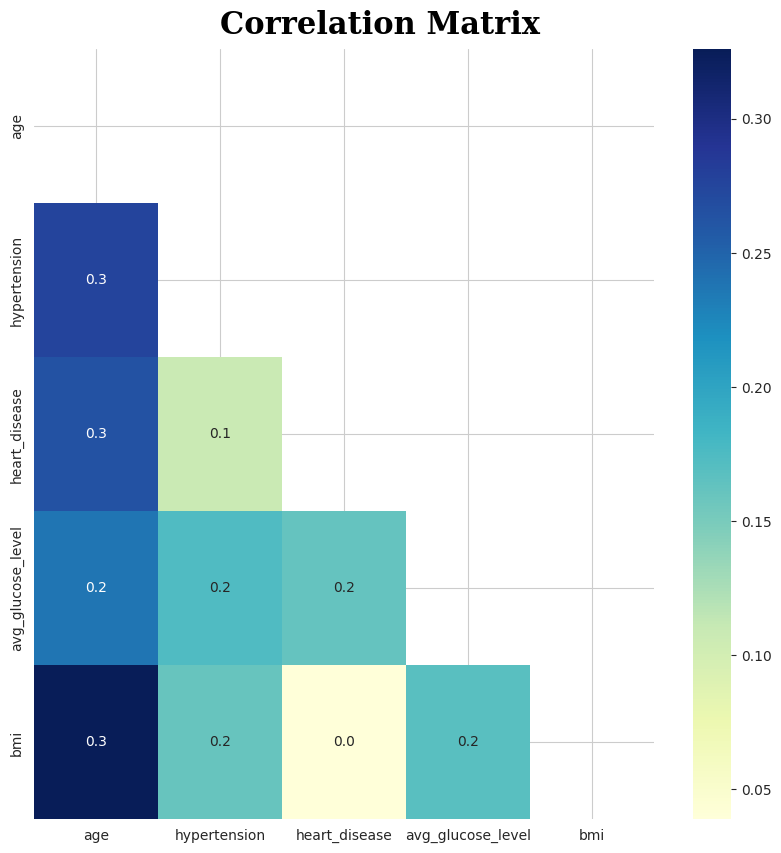

In [35]:
data_corr = data[num_cols].corr()
data_corr


fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(1,1)
gs.update(wspace=0.3, hspace=0.15)
ax0 = fig.add_subplot(gs[0,0])

color_palette = ["#94a3b8","#64748b"]
mask = np.triu(np.ones_like(data_corr))
ax0.text(1.5,-0.1,"Correlation Matrix",fontsize=22, fontweight='bold', fontfamily='serif', color="#000000")
df_corr = data[num_cols].corr().transpose()
sns.heatmap(df_corr,mask=mask,fmt=".1f",annot=True,cmap='YlGnBu')
plt.show()

# Modeling

Evaluating Logistic Regression...
Evaluating Support Vector Classifier...
Evaluating Decision Tree...
Evaluating Random Forest...
Evaluating Gradient Boosting...

Model Evaluation Results:
                           Accuracy  Precision    Recall  F1 Score   ROC AUC  \
Logistic Regression        0.939335   0.000000  0.000000   0.00000  0.851680   
Support Vector Classifier  0.939335   0.000000  0.000000   0.00000  0.653125   
Decision Tree              0.910959   0.215686  0.177419   0.19469  0.567876   
Random Forest              0.939335   0.500000  0.016129   0.03125  0.812189   
Gradient Boosting          0.939335   0.500000  0.016129   0.03125  0.835786   

                           Training Time (s)  
Logistic Regression                 0.022087  
Support Vector Classifier           1.362792  
Decision Tree                       0.015346  
Random Forest                       0.475489  
Gradient Boosting                   0.541786  


<Figure size 1200x800 with 0 Axes>

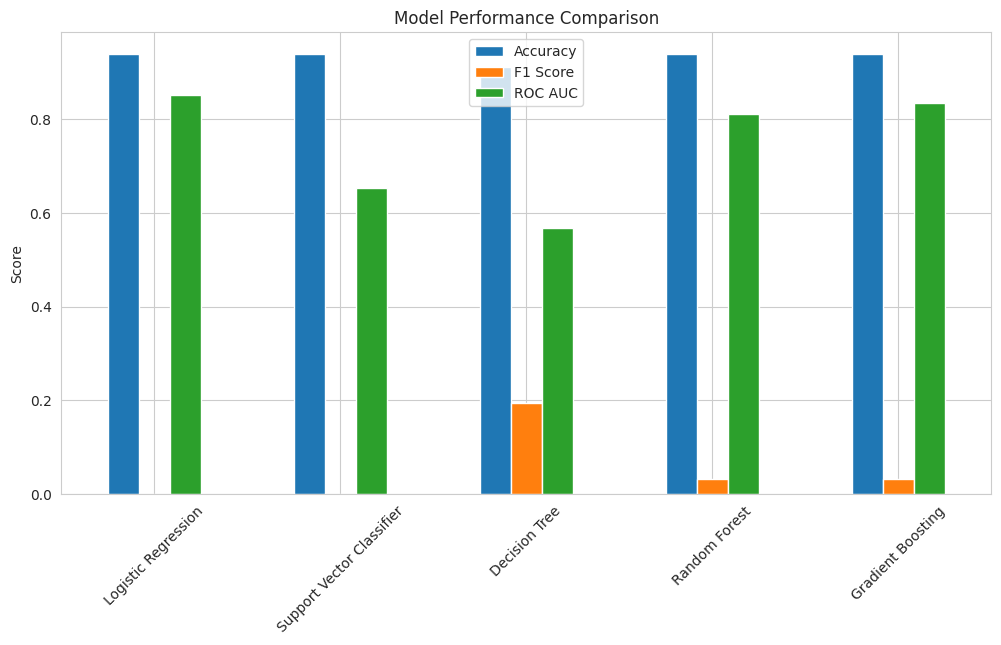


The best model based on F1 Score is: Decision Tree with F1 Score: 0.19


In [37]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import time

# Prepare the data
# Select categorical and numerical features
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
numerical_cols = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']

# Apply label encoding to categorical features
label_encoders = {col: LabelEncoder() for col in categorical_cols}
for col in categorical_cols:
    data[col] = label_encoders[col].fit_transform(data[col])

# Define the feature matrix (X) and target variable (y)
X = data[categorical_cols + numerical_cols]
y = data['stroke']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = RobustScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Initialize models to evaluate
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Support Vector Classifier": SVC(probability=True, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Evaluation function
def evaluate_model(model, X_train, y_train, X_test, y_test):
    start_time = time.time()
    # Train the model
    model.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate metrics
    results = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1 Score": f1_score(y_test, y_pred, zero_division=0),
        "ROC AUC": roc_auc_score(y_test, y_pred_prob) if y_pred_prob is not None else "N/A",
        "Training Time (s)": training_time
    }
    return results

# Evaluate all models
results = {}
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    results[model_name] = evaluate_model(model, X_train, y_train, X_test, y_test)

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results).transpose()

# Display the results
print("\nModel Evaluation Results:")
print(results_df)

# Plot the results
plt.figure(figsize=(12, 8))
results_df[["Accuracy", "F1 Score", "ROC AUC"]].plot(kind="bar", figsize=(12, 6), title="Model Performance Comparison", rot=45)
plt.ylabel("Score")
plt.show()

# Highlight the best model based on F1 Score
best_model = results_df["F1 Score"].idxmax()
print(f"\nThe best model based on F1 Score is: {best_model} with F1 Score: {results_df.loc[best_model, 'F1 Score']:.2f}")